# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

# Imposta il seed
seed = 40  # Variabile per il seed
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [ ]:
data = np.load("/kaggle/input/mars-for-students-npz/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
def calculate_class_proportions(label, num_classes):
    """
    Calculate the proportion of each class in a semantic segmentation label image.
    Args:
        label (numpy array): Label image (height, width).
        num_classes (int): Total number of classes.
    Returns:
        dict: Dictionary with class indices as keys and proportions as values.
    """
    total_pixels = label.size  # Total number of pixels in the image
    proportions = {}

    for class_id in range(num_classes):
        class_pixels = np.sum(label == class_id)  # Count pixels of the current class
        proportions[class_id] = class_pixels / total_pixels  # Proportion of this class

    return proportions

# Calculate aliens-images class proportions
num_classes = 5  # Background, Soil, Bedrock, Sand, Big Rock
example_label = y_train[1092]

aliens_proportions = calculate_class_proportions(example_label, num_classes)
print("Class Proportions:", aliens_proportions)

X_train_filtered = []
y_train_filtered = []
X_outliers = []
y_outliers = []
# Filtra i campioni
filtered_indices = []
for i, label in enumerate(y_train):
    proportions = calculate_class_proportions(label, num_classes=5)
    if proportions == aliens_proportions:  # Samples for removal
        X_outliers.append(X_train[i])
        y_outliers.append(y_train[i])
    else:  # Acceptable samples
        X_train_filtered.append(X_train[i])
        y_train_filtered.append(y_train[i])



print(f"Numero di campioni originali: {len(X_train)}")
print(f"Numero di campioni filtrati: {len(X_train_filtered)}")

Class Proportions: {0: 0.530517578125, 1: 0.192626953125, 2: 0.0966796875, 3: 0.18017578125, 4: 0.0}
Numero di campioni originali: 2615
Numero di campioni filtrati: 2505


In [ ]:
X_train = np.array(X_train_filtered)
y_train = np.array(y_train_filtered)

print(f"Shape di X_train_filtered: {X_train.shape}")
print(f"Shape di y_train_filtered: {y_train.shape}")

Shape di X_train_filtered: (2505, 64, 128)
Shape di y_train_filtered: (2505, 64, 128)


In [ ]:
num_classes = 5

# Array to count pixels for each class
class_pixel_counts = np.zeros(num_classes, dtype=np.int64)

# Count the pixels of each class in the dataset
for mask in y_train:
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        if 0 <= cls < num_classes:  # Verifica che la classe sia valida
            class_pixel_counts[int(cls)] += count

# Calculate the total pixels
total_pixels = np.sum(class_pixel_counts)  # Pixel totali
background_pixels = class_pixel_counts[0]  # Pixel della classe background (0)
non_background_pixels = total_pixels - background_pixels  # Pixel di tutte le altre classi

# Calculate the percentage for each class
percentages = (class_pixel_counts / total_pixels) * 100

Classe 0: 24.31%
Classe 1: 33.90%
Classe 2: 23.28%
Classe 3: 18.38%
Classe 4: 0.13%

Percentuale di background rispetto a tutte le altre classi: 32.12%


In [ ]:
# Identify images that contain only background
only_background = [i for i, mask in enumerate(y_train) if np.all(mask == 0)]

print(f"Number of images with only background: {len(only_background)}")

Number of images with only background: 7


In [ ]:
# Threshold for the background
background_threshold = 0.8  # 80%

X_train_filtered = []
y_train_filtered = []

for img, mask in zip(X_train, y_train):
    # Calculate the percentage of background
    total_pixels = mask.size
    background_pixels = np.sum(mask == 0)
    background_ratio = background_pixels / total_pixels

    # Keep images with less than 80% background
    if background_ratio < background_threshold:
        X_train_filtered.append(img)
        y_train_filtered.append(mask)

# Converts filtered lists to NumPy arrays
X_train_filtered = np.array(X_train_filtered)
y_train_filtered = np.array(y_train_filtered)

print(f"Original dataset size: {len(X_train)}")
print(f"Filtered dataset size: {len(X_train_filtered)}")

Original dataset size: 2505
Filtered dataset size: 2248


In [ ]:
print(f"Shape di X_train_filtered: {X_train_filtered.shape}")
print(f"Shape di y_train_filtered: {y_train_filtered.shape}")

Shape di X_train_filtered: (2248, 64, 128)
Shape di y_train_filtered: (2248, 64, 128)


In [ ]:
# Statistical data analysis
print('Data shape:', X_train_filtered.shape)
print('Data min: {:0.2f}\nData max: {:0.2f}\nData mean: {:0.2f}\nData std: {:0.2f}'.format(
    X_train_filtered.min(), X_train_filtered.max(), X_train_filtered.mean(), X_train_filtered.std()))

# Define input shape for the model
input_shape = X_train_filtered.shape[1:]

# Print input shape
print(f"Input shape: {input_shape}")

Data shape: (2248, 64, 128)
Data min: 2.00
Data max: 254.00
Data mean: 62.02
Data std: 25.55
Input shape: (64, 128)


## Augmentation

In [ ]:
def cutmix(image1, mask1, image2, mask2):
    """
    Applica CutMix a due immagini e maschere.

    Args:
        image1, image2: Immagini in scala di grigi (H, W, 1) o (H, W).
        mask1, mask2: Maschere corrispondenti (H, W).

    Returns:
        Tuple: Immagine e maschera CutMix.
    """
    # Remove extra channel from images if necessary
    if len(image1.shape) == 3:  # (H, W, 1)
        image1 = np.squeeze(image1, axis=-1)
        image2 = np.squeeze(image2, axis=-1)

    h, w = image1.shape

    # Genera coordinate casuali per il ritaglio
    cut_x = np.random.randint(0, w)
    cut_y = np.random.randint(0, h)
    cut_w = np.random.randint(w // 4, w // 2)
    cut_h = np.random.randint(h // 4, h // 2)

    # Definisci i limiti del rettangolo
    x1 = np.clip(cut_x - cut_w // 2, 0, w)
    x2 = np.clip(cut_x + cut_w // 2, 0, w)
    y1 = np.clip(cut_y - cut_h // 2, 0, h)
    y2 = np.clip(cut_y + cut_h // 2, 0, h)

    # Crea immagine e maschera CutMix
    mixed_image = image1.copy()
    mixed_image[y1:y2, x1:x2] = image2[y1:y2, x1:x2]

    mixed_mask = mask1.copy()
    mixed_mask[y1:y2, x1:x2] = mask2[y1:y2, x1:x2]

    # Ritorna la dimensione del canale per le immagini
    mixed_image = np.expand_dims(mixed_image, axis=-1)  # (H, W, 1)

    return mixed_image, mixed_mask

In [ ]:
@tf.function
def augment_image_and_mask(image, mask):
    """
    Applica augmentation con flip orizzontale casuale a immagine e maschera.
    """
    # Aggiungi una dimensione del canale alla maschera e immagine se necessario
    if len(image.shape) == 2:  # Controlla se l'immagine è bidimensionale
        image = tf.expand_dims(image, axis=-1)  # Aggiungi una dimensione del canale
    if len(mask.shape) == 2:  # Controlla se la maschera è bidimensionale
        mask = tf.expand_dims(mask, axis=-1)  # Aggiungi una dimensione del canale

    # Flip orizzontale casuale
    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    else:
        # Flip verticale casuale
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    return image, mask

## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 40

# Set maximum number of training epochs
EPOCHS = 230

# Set data split size for training and validation
SPLITS_SIZE = 300

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train_filtered[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train_filtered

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def unet_block_with_aspp(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name='', aspp_rates=[6, 12, 18, 24], num_classes=5):
    # Initialise the input tensor
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # ASPP modification to accommodate class size
    x = aspp_module(x, filters, num_classes, aspp_rates)

    # Output finale con il numero di canali corrispondente alle classi
    outputs = tf.keras.layers.Conv2D(num_classes, 1)(x)
    return outputs

In [ ]:
import tensorflow as tf

def aspp_module(inputs, filters, num_classes=5, rate=[6, 12, 18, 24]):

    # Image-level features
    shape = inputs.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(x)

    # Parallel dilated convolutions
    convs = []
    for r in rate:
        conv = tf.keras.layers.Conv2D(filters, 3, padding='same', dilation_rate=r, use_bias=False)(inputs)
        conv = tf.keras.layers.BatchNormalization()(conv)
        convs.append(conv)

    # Concatenate all layers
    x = tf.keras.layers.Concatenate()([x] + convs)

    # Final 1x1 convolution
    x = tf.keras.layers.Conv2D(num_classes, 1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x

In [ ]:
def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]
    # Squeeze: Global average pooling
    se = tfkl.GlobalAveragePooling2D()(input_tensor)
    se = tfkl.Dense(channels // ratio, activation='relu')(se)
    se = tfkl.Dense(channels, activation='sigmoid')(se)
    # Excite: Scale the input tensor
    se = tfkl.Multiply()([input_tensor, se])  # Element-wise multiplication
    return se

In [ ]:
from tensorflow.keras.regularizers import l2
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Atrous Spatial Pyramid Pooling before bottleneck
    d2 = unet_block_with_aspp(d2, 256)

    # Bottleneck: choke point where feature maps are filtered and compressed
    bottleneck = unet_block(d2, 32, name='bottleneck')
    bottleneck = se_block(bottleneck)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])

    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer + kernel regularization
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",kernel_regularizer=l2(0.01), name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1 (Conv2D)    │ (None, 16, 32,  │   147,712 │ max_pooling2d… │   Y   │
│                   │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bn1               │ (None, 16, 32,  │     1,024 │ conv1[0][0]    │   Y 

 Total params: 3,383,424 (12.91 MB)

 Trainable params: 3,378,934 (12.89 MB)

 Non-trainable params: 4,490 (17.54 KB)

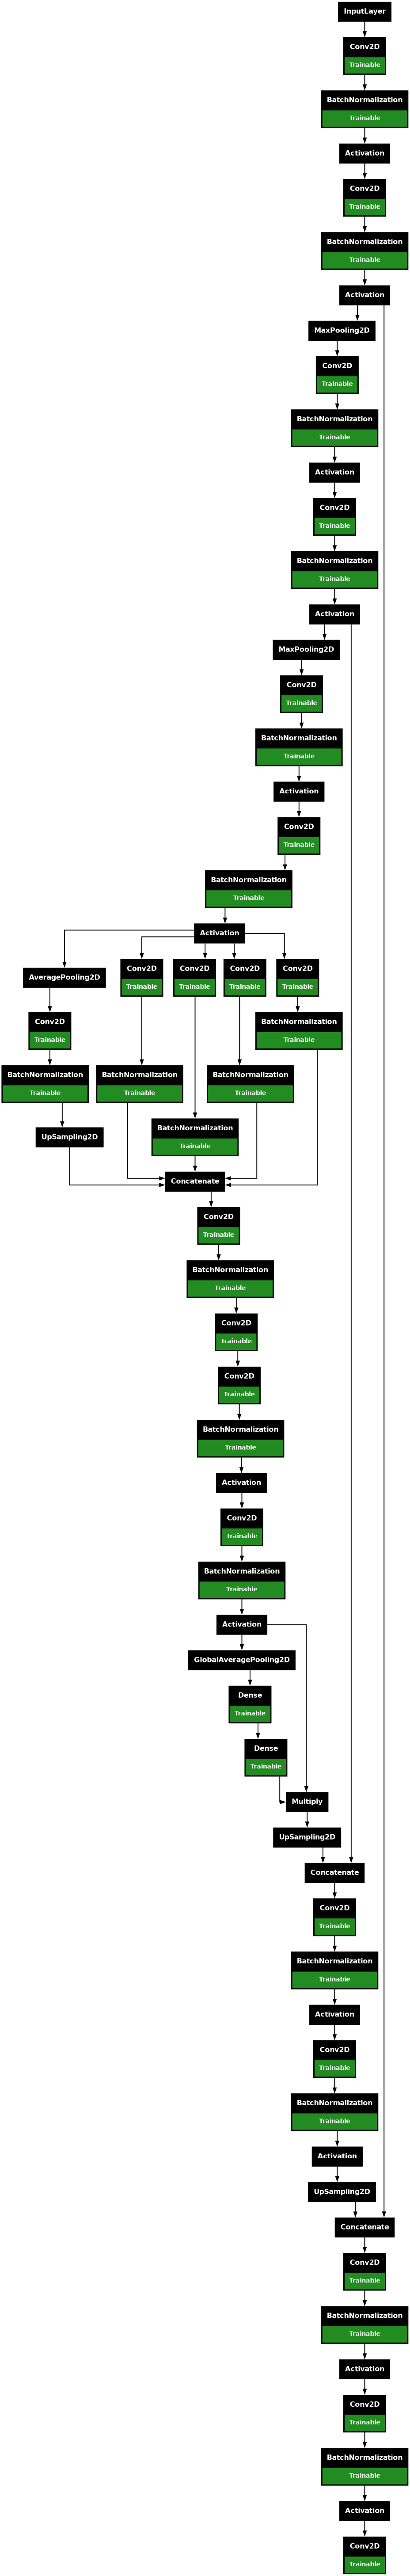

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, **kwargs):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, **kwargs)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, frequency=5):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            idx = np.random.randint(0, len(self.X_train))
            image = self.X_train[idx]
            label = self.y_train[idx]

            image = np.expand_dims(image, axis=0)

            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]

            class_colors = ['black', 'brown', 'gray', 'yellow', 'red']
            num_classes = len(class_colors)
            colormap = ListedColormap(class_colors)

            plt.figure(figsize=(16, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(image[0, :, :, 0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(label, cmap=colormap, vmin=0, vmax=num_classes - 1)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred, cmap=colormap, vmin=0, vmax=num_classes - 1)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Set the fraction of validation set (example: 30%)
validation_fraction = 0.3

# Split the dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=validation_fraction, random_state=seed
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 1573
Validation set size: 675


In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1573, 64, 128, 1)
Shape of y_train: (1573, 64, 128)


Original dataset size: 1573
Augmented dataset size: 5069


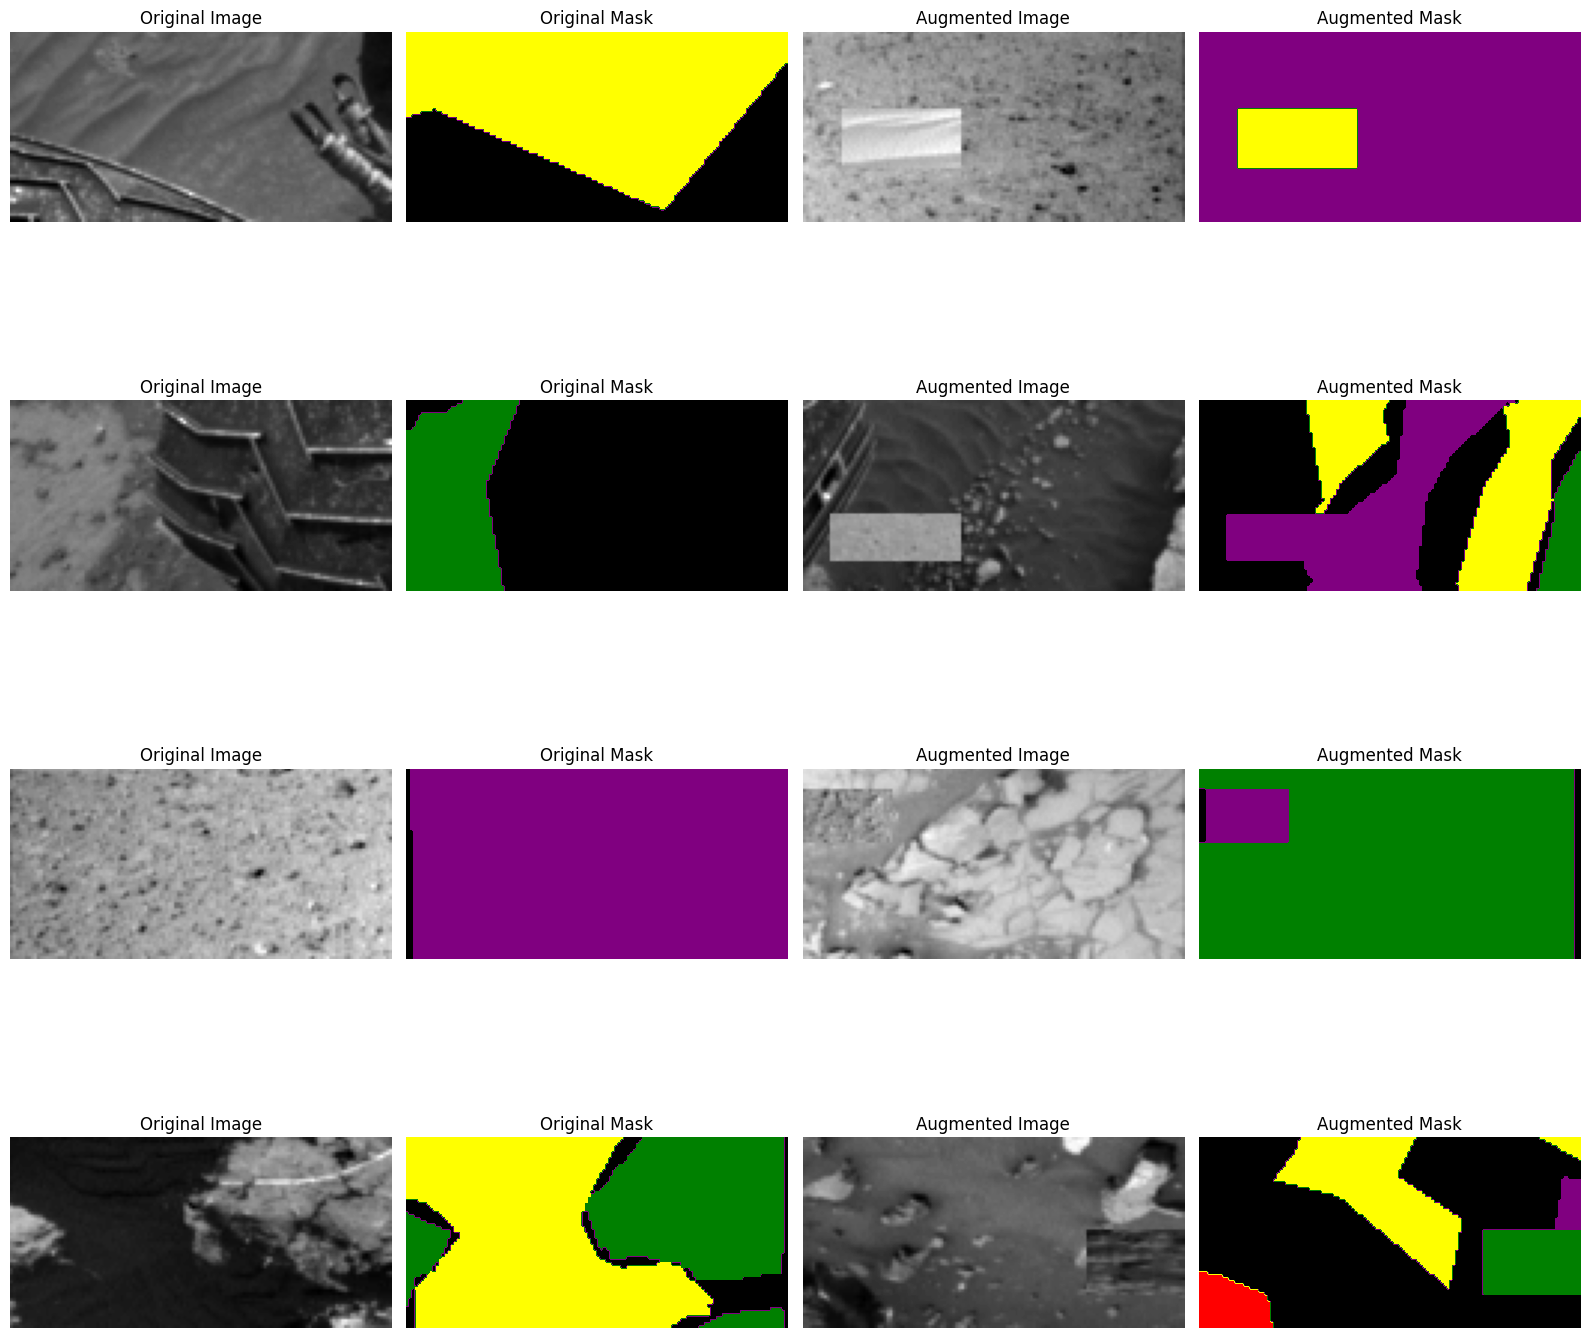

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def augment_training_set(X_train, y_train, num_augmentations):
    """
    Applica CutMix e flip orizzontale al dataset di training.

    Args:
        X_train: Array di immagini (num_samples, H, W, 1).
        y_train: Array di maschere (num_samples, H, W).
        num_augmentations: Numero totale di augmentation da creare.

    Returns:
        Tuple: Nuovi array (X_train_augmented, y_train_augmented).
    """
    augmented_X = []
    augmented_y = []

    for _ in range(num_augmentations):
        # Random select two images
        idx1, idx2 = np.random.choice(len(X_train), size=2, replace=False)
        img1, mask1 = X_train[idx1], y_train[idx1]
        img2, mask2 = X_train[idx2], y_train[idx2]

        # Apply CutMix
        mixed_image, mixed_mask = cutmix(img1, mask1, img2, mask2)

        # Apply flip
        flipped_image, flipped_mask = augment_image_and_mask(
            tf.convert_to_tensor(mixed_image, dtype=tf.float32),
            tf.convert_to_tensor(mixed_mask, dtype=tf.int32)
        )

        flipped_image = flipped_image.numpy()
        flipped_mask = flipped_mask.numpy()


        augmented_X.append(flipped_image)
        augmented_y.append(flipped_mask)

    augmented_y = [np.squeeze(mask, axis=-1) if len(mask.shape) == 3 else mask for mask in augmented_y]

    X_train_augmented = np.concatenate([X_train] + [np.array(augmented_X)], axis=0)
    y_train_augmented = np.concatenate([y_train] + [np.array(augmented_y)], axis=0)

    return X_train_augmented, y_train_augmented

def visualize_augmentation_examples(X_train, y_train, X_augmented, y_augmented, num_examples=4):

    cmap = ListedColormap(['black', 'purple', 'green', 'yellow', 'red'])

    fig, axs = plt.subplots(num_examples, 4, figsize=(16, 4 * num_examples))

    for i in range(num_examples):
        idx = np.random.randint(0, len(X_train))
        idx_aug = np.random.randint(0, len(X_augmented))

        axs[i, 0].imshow(X_train[idx, :, :, 0], cmap="gray")
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(y_train[idx], cmap=cmap, vmin=0, vmax=4)
        axs[i, 1].set_title("Original Mask")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(X_augmented[idx_aug, :, :, 0], cmap="gray")
        axs[i, 2].set_title("Augmented Image")
        axs[i, 2].axis("off")

        axs[i, 3].imshow(y_augmented[idx_aug], cmap=cmap, vmin=0, vmax=4)
        axs[i, 3].set_title("Augmented Mask")
        axs[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

num_augmentations = 3496
X_train_augmented, y_train_augmented = augment_training_set(X_train, y_train, num_augmentations)

print(f"Original dataset size: {X_train.shape[0]}")
print(f"Augmented dataset size: {X_train_augmented.shape[0]}")

visualize_augmentation_examples(X_train, y_train, X_train_augmented, y_train_augmented, num_examples=4)

In [ ]:
from tensorflow.keras.saving import register_keras_serializable

def compute_class_weights(y_train, num_classes=5):
    """
    Compute class weights for segmentation masks.

    Args:
        y_train (list of numpy arrays): List of segmentation masks.
        num_classes (int): Total number of classes.

    Returns:
        numpy array: Array of class weights.
    """
    class_pixel_counts = np.zeros(num_classes, dtype=np.float64)
    total_pixels = 0

    # Count the total number of pixels for each class
    for mask in y_train:
        for class_id in range(num_classes):
            class_pixel_counts[class_id] += np.sum(mask == class_id)
        total_pixels += mask.size

    # Avoid division by zero by adding a small epsilon to counts
    epsilon = 1e-6
    class_weights = total_pixels / (class_pixel_counts + epsilon)

    # Normalize the weights so that the average is 1
    class_weights /= np.mean(class_weights)

    return class_weights

# Compute class weights for the filtered training set
class_weights = compute_class_weights(y_train_augmented, num_classes=5)

# Print the computed class weights
print(f"Computed class weights: {class_weights}")

@register_keras_serializable()
class WeightedCategoricalCrossentropy:
    def __init__(self, class_weights):
        """
        A custom loss function for weighted categorical cross-entropy.

        Args:
            class_weights (numpy array or list): Array of weights for each class.
        """
        self.class_weights = tf.constant(class_weights, dtype=tf.float32)

    def __call__(self, y_true, y_pred):
        """
        Compute the weighted categorical cross-entropy loss.

        Args:
            y_true (tensor): Ground truth labels, shape (batch_size, height, width).
            y_pred (tensor): Predicted logits, shape (batch_size, height, width, num_classes).

        Returns:
            tensor: Weighted categorical cross-entropy loss.
        """
        # One-hot encode y_true
        # y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(self.class_weights))
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.class_weights.shape[0])
        # Apply softmax to y_pred
        y_pred_softmax = tf.nn.softmax(y_pred, axis=-1)
        # Compute pixel-wise cross-entropy
        cross_entropy = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred_softmax + 1e-6), axis=-1)
        # Apply class weights
        weights = tf.reduce_sum(y_true_one_hot * self.class_weights, axis=-1)
        weighted_cross_entropy = weights * cross_entropy
        return tf.reduce_mean(weighted_cross_entropy)

    def get_config(self):
        """
        Returns the configuration of the loss function for serialization.
        """
        return {'class_weights': self.class_weights.numpy().tolist()}

    @classmethod
    def from_config(cls, config):
        """
        Reconstructs the class instance from the configuration dictionary.
        """
        return cls(config['class_weights'])

loss_function = WeightedCategoricalCrossentropy(class_weights)
# Compile the model
print("Compiling model...")
model.compile(
    loss=loss_function,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)
print("Model compiled!")


Computed class weights: [0.03637445 0.01599065 0.02359891 0.02946915 4.89456684]
Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
# from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_intersection_over_union',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)
viz_callback = VizCallback(X_val, y_val)

Epoch 1/230


I0000 00:00:1733957700.647224      67 service.cc:145] XLA service 0x78cc84274d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733957700.647282      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/159 ━━━━━━━━━━━━━━━━━━━━ 1:32:43 35s/step - accuracy: 0.2146 - loss: 0.0688 - mean_intersection_over_union: 0.0811

I0000 00:00:1733957725.874218      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.3471 - loss: 0.0446 - mean_intersection_over_union: 0.1723

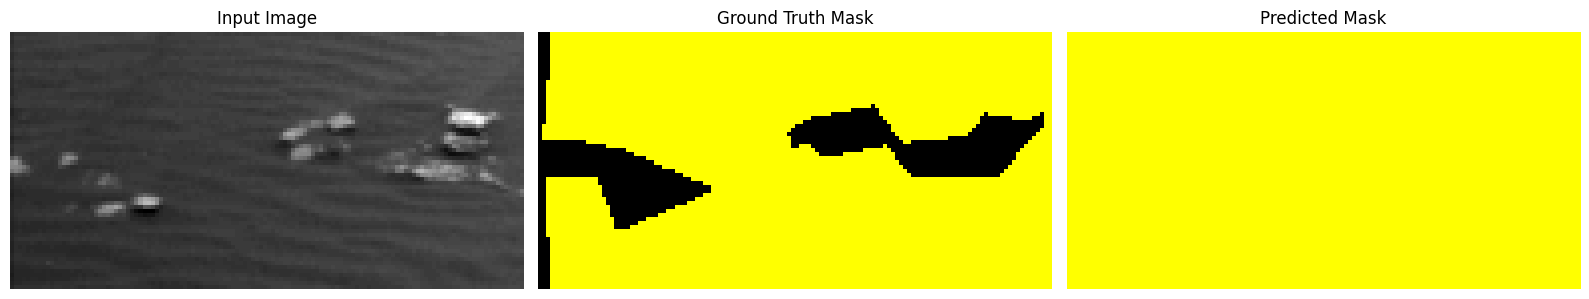

159/159 ━━━━━━━━━━━━━━━━━━━━ 78s 270ms/step - accuracy: 0.3475 - loss: 0.0446 - mean_intersection_over_union: 0.1726 - val_accuracy: 0.2118 - val_loss: 0.0543 - val_mean_intersection_over_union: 0.0632
Epoch 2/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.5171 - loss: 0.0415 - mean_intersection_over_union: 0.2802 - val_accuracy: 0.2118 - val_loss: 0.0543 - val_mean_intersection_over_union: 0.0632
Epoch 3/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.5625 - loss: 0.0409 - mean_intersection_over_union: 0.3107 - val_accuracy: 0.2143 - val_loss: 0.0542 - val_mean_intersection_over_union: 0.0518
Epoch 4/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.5974 - loss: 0.0395 - mean_intersection_over_union: 0.3388 - val_accuracy: 0.3623 - val_loss: 0.0489 - val_mean_intersection_over_union: 0.1561
Epoch 5/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.6163 - loss: 0.0389 - mean_intersection_over_union: 0.3517 - val_accuracy: 0.5588 - va

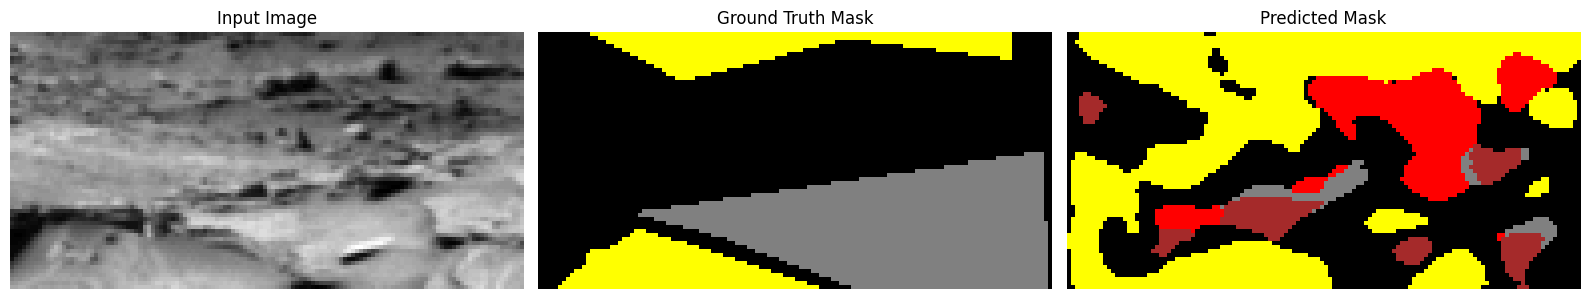

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.6350 - loss: 0.0384 - mean_intersection_over_union: 0.3671 - val_accuracy: 0.5342 - val_loss: 0.0461 - val_mean_intersection_over_union: 0.2712
Epoch 7/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.6422 - loss: 0.0380 - mean_intersection_over_union: 0.3713 - val_accuracy: 0.5623 - val_loss: 0.0442 - val_mean_intersection_over_union: 0.3218
Epoch 8/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.6460 - loss: 0.0379 - mean_intersection_over_union: 0.3764 - val_accuracy: 0.5523 - val_loss: 0.0426 - val_mean_intersection_over_union: 0.3192
Epoch 9/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6569 - loss: 0.0376 - mean_intersection_over_union: 0.3828 - val_accuracy: 0.5111 - val_loss: 0.0434 - val_mean_intersection_over_union: 0.2720
Epoch 10/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6191 - loss: 0.0383 - mean_intersection_over_union: 0.3534 - val_accuracy: 0.4544 - v

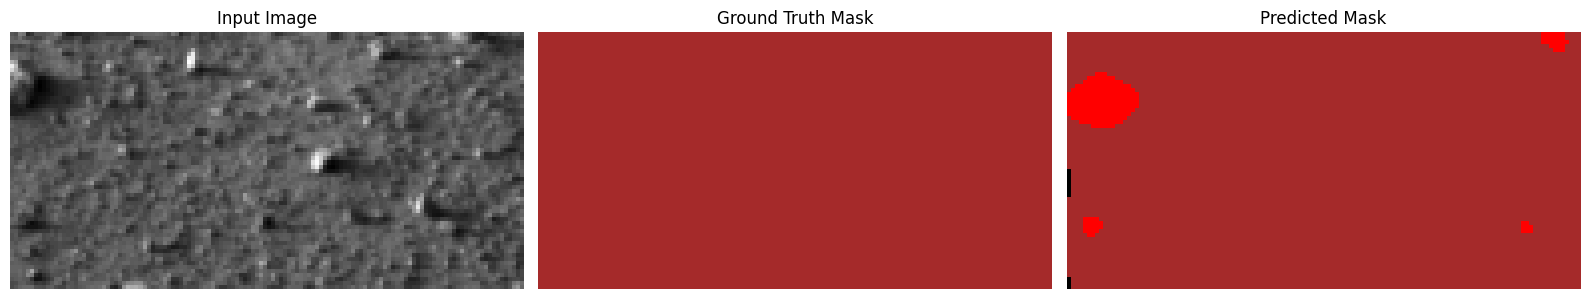

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.6612 - loss: 0.0372 - mean_intersection_over_union: 0.3841 - val_accuracy: 0.3806 - val_loss: 0.0443 - val_mean_intersection_over_union: 0.2350
Epoch 12/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6546 - loss: 0.0375 - mean_intersection_over_union: 0.3812 - val_accuracy: 0.4091 - val_loss: 0.0454 - val_mean_intersection_over_union: 0.2095
Epoch 13/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6613 - loss: 0.0372 - mean_intersection_over_union: 0.3847 - val_accuracy: 0.5254 - val_loss: 0.0439 - val_mean_intersection_over_union: 0.2724
Epoch 14/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6790 - loss: 0.0367 - mean_intersection_over_union: 0.3983 - val_accuracy: 0.4386 - val_loss: 0.0461 - val_mean_intersection_over_union: 0.2239
Epoch 15/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6809 - loss: 0.0367 - mean_intersection_over_union: 0.4002 - val_accuracy: 0.4836 

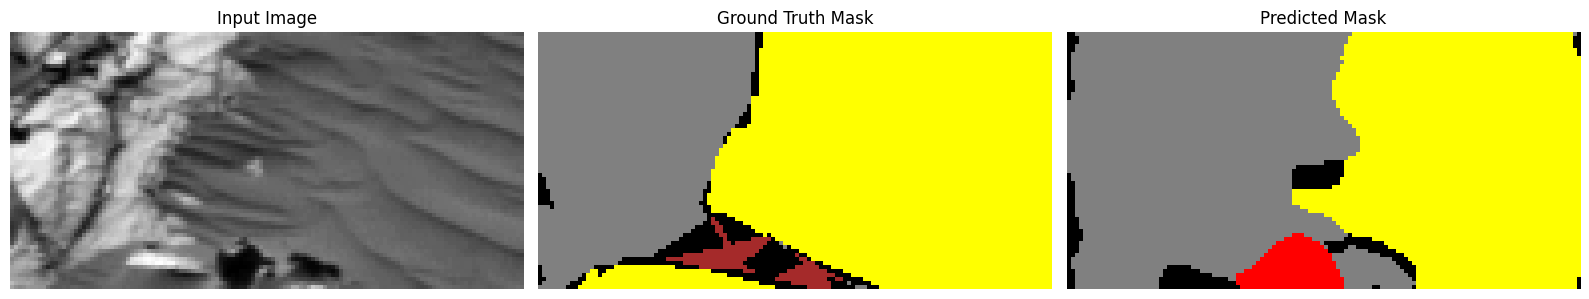

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.6875 - loss: 0.0364 - mean_intersection_over_union: 0.4047 - val_accuracy: 0.6248 - val_loss: 0.0424 - val_mean_intersection_over_union: 0.3668
Epoch 17/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6956 - loss: 0.0362 - mean_intersection_over_union: 0.4117 - val_accuracy: 0.6325 - val_loss: 0.0436 - val_mean_intersection_over_union: 0.3576
Epoch 18/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7048 - loss: 0.0359 - mean_intersection_over_union: 0.4211 - val_accuracy: 0.6455 - val_loss: 0.0437 - val_mean_intersection_over_union: 0.3669
Epoch 19/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7033 - loss: 0.0359 - mean_intersection_over_union: 0.4193 - val_accuracy: 0.5671 - val_loss: 0.0425 - val_mean_intersection_over_union: 0.3071
Epoch 20/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7057 - loss: 0.0358 - mean_intersection_over_union: 0.4221 - val_accuracy: 0.5979 

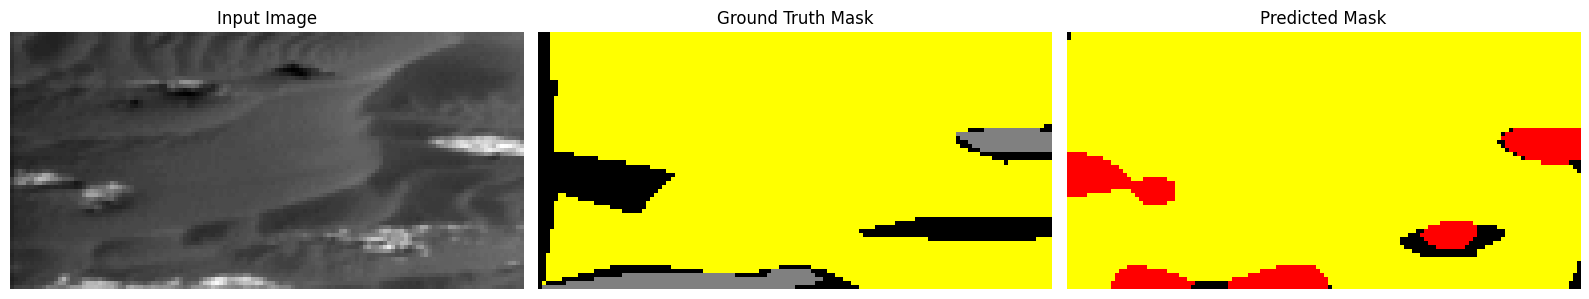

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.7143 - loss: 0.0357 - mean_intersection_over_union: 0.4294 - val_accuracy: 0.5315 - val_loss: 0.0432 - val_mean_intersection_over_union: 0.2921
Epoch 22/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6665 - loss: 0.0371 - mean_intersection_over_union: 0.3899 - val_accuracy: 0.6374 - val_loss: 0.0424 - val_mean_intersection_over_union: 0.3635
Epoch 23/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7145 - loss: 0.0356 - mean_intersection_over_union: 0.4302 - val_accuracy: 0.4846 - val_loss: 0.0464 - val_mean_intersection_over_union: 0.2513
Epoch 24/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7132 - loss: 0.0356 - mean_intersection_over_union: 0.4274 - val_accuracy: 0.5565 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.3084
Epoch 25/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7092 - loss: 0.0357 - mean_intersection_over_union: 0.4212 - val_accuracy: 0.6034 

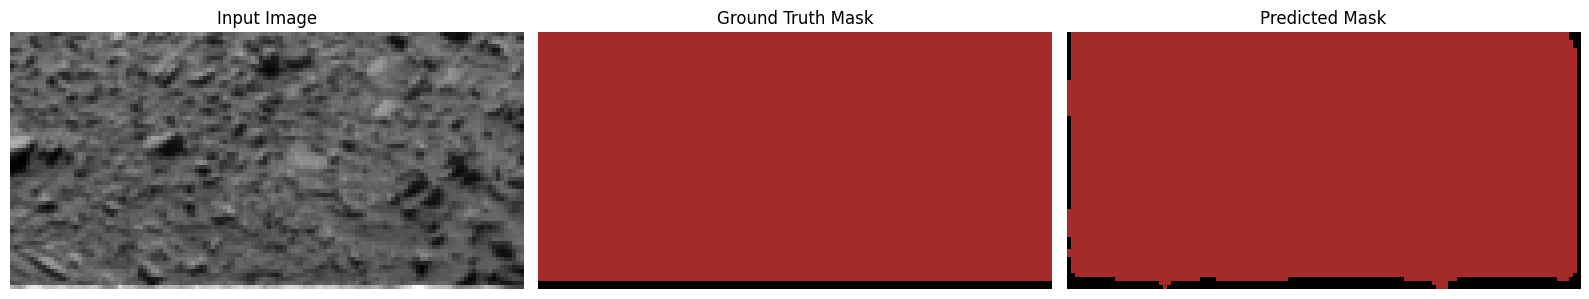

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.7006 - loss: 0.0362 - mean_intersection_over_union: 0.4177 - val_accuracy: 0.6423 - val_loss: 0.0439 - val_mean_intersection_over_union: 0.3602
Epoch 27/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.6822 - loss: 0.0366 - mean_intersection_over_union: 0.4016 - val_accuracy: 0.5879 - val_loss: 0.0431 - val_mean_intersection_over_union: 0.3110
Epoch 28/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7177 - loss: 0.0355 - mean_intersection_over_union: 0.4325 - val_accuracy: 0.6704 - val_loss: 0.0423 - val_mean_intersection_over_union: 0.3905
Epoch 29/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7268 - loss: 0.0352 - mean_intersection_over_union: 0.4425 - val_accuracy: 0.6185 - val_loss: 0.0437 - val_mean_intersection_over_union: 0.3592
Epoch 30/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7317 - loss: 0.0352 - mean_intersection_over_union: 0.4471 - val_accuracy: 0.6547 

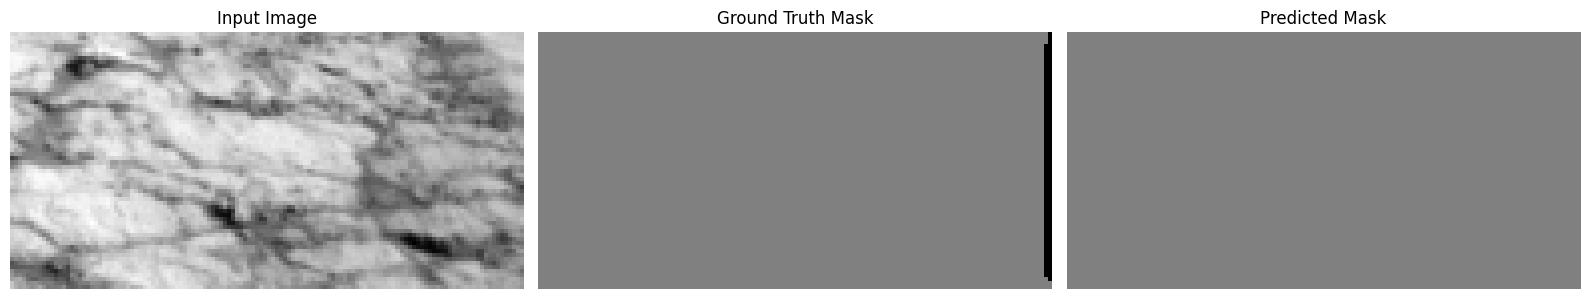

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.7353 - loss: 0.0350 - mean_intersection_over_union: 0.4524 - val_accuracy: 0.7269 - val_loss: 0.0423 - val_mean_intersection_over_union: 0.4417
Epoch 32/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7353 - loss: 0.0351 - mean_intersection_over_union: 0.4522 - val_accuracy: 0.4982 - val_loss: 0.0440 - val_mean_intersection_over_union: 0.2727
Epoch 33/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7224 - loss: 0.0354 - mean_intersection_over_union: 0.4353 - val_accuracy: 0.6177 - val_loss: 0.0442 - val_mean_intersection_over_union: 0.3491
Epoch 34/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7382 - loss: 0.0350 - mean_intersection_over_union: 0.4530 - val_accuracy: 0.7037 - val_loss: 0.0425 - val_mean_intersection_over_union: 0.4115
Epoch 35/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7448 - loss: 0.0348 - mean_intersection_over_union: 0.4594 - val_accuracy: 0.3663 

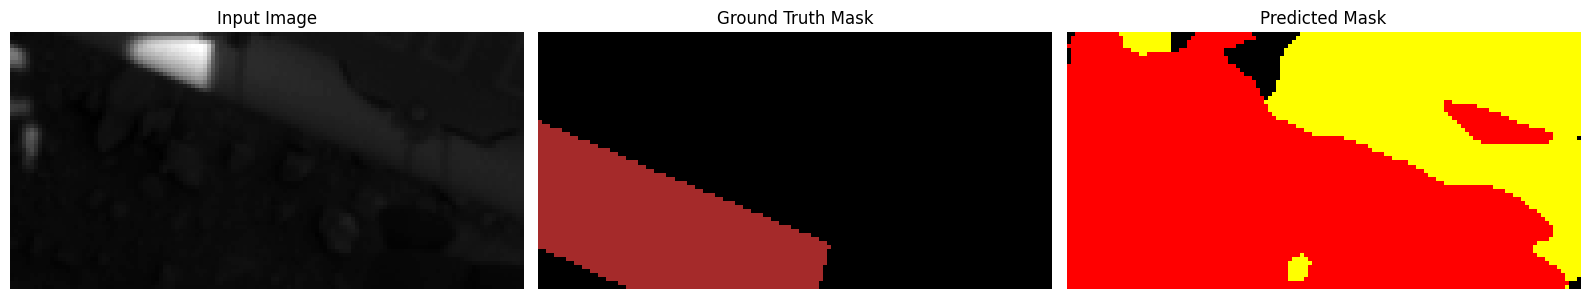

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.6857 - loss: 0.0366 - mean_intersection_over_union: 0.4009 - val_accuracy: 0.6499 - val_loss: 0.0417 - val_mean_intersection_over_union: 0.3920
Epoch 37/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7233 - loss: 0.0354 - mean_intersection_over_union: 0.4376 - val_accuracy: 0.7335 - val_loss: 0.0417 - val_mean_intersection_over_union: 0.4454
Epoch 38/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7454 - loss: 0.0348 - mean_intersection_over_union: 0.4647 - val_accuracy: 0.7146 - val_loss: 0.0406 - val_mean_intersection_over_union: 0.4365
Epoch 39/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7460 - loss: 0.0347 - mean_intersection_over_union: 0.4653 - val_accuracy: 0.7358 - val_loss: 0.0408 - val_mean_intersection_over_union: 0.4542
Epoch 40/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7531 - loss: 0.0346 - mean_intersection_over_union: 0.4732 - val_accuracy: 0.6776 

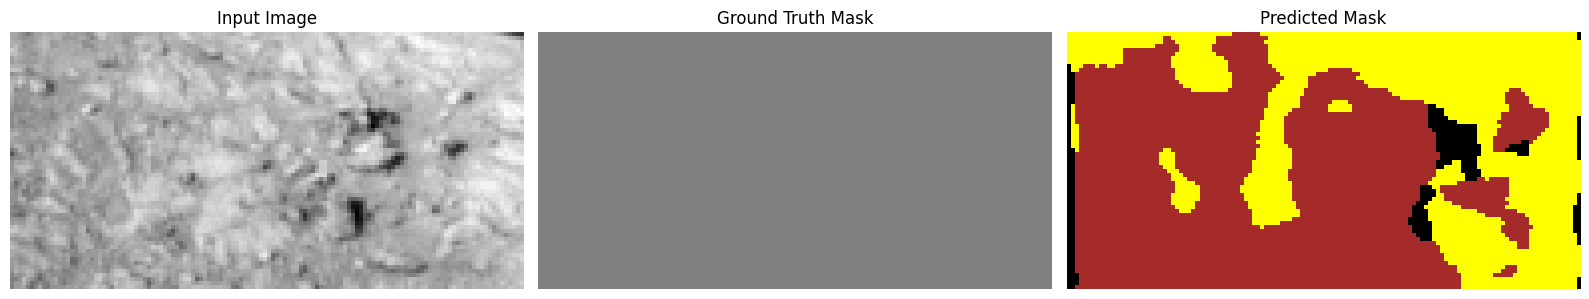

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.7368 - loss: 0.0351 - mean_intersection_over_union: 0.4496 - val_accuracy: 0.6771 - val_loss: 0.0419 - val_mean_intersection_over_union: 0.3950
Epoch 42/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7538 - loss: 0.0345 - mean_intersection_over_union: 0.4715 - val_accuracy: 0.5569 - val_loss: 0.0450 - val_mean_intersection_over_union: 0.3117
Epoch 43/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7555 - loss: 0.0345 - mean_intersection_over_union: 0.4766 - val_accuracy: 0.7285 - val_loss: 0.0415 - val_mean_intersection_over_union: 0.4489
Epoch 44/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7556 - loss: 0.0345 - mean_intersection_over_union: 0.4785 - val_accuracy: 0.7109 - val_loss: 0.0420 - val_mean_intersection_over_union: 0.4273
Epoch 45/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7646 - loss: 0.0342 - mean_intersection_over_union: 0.4893 - val_accuracy: 0.7391 

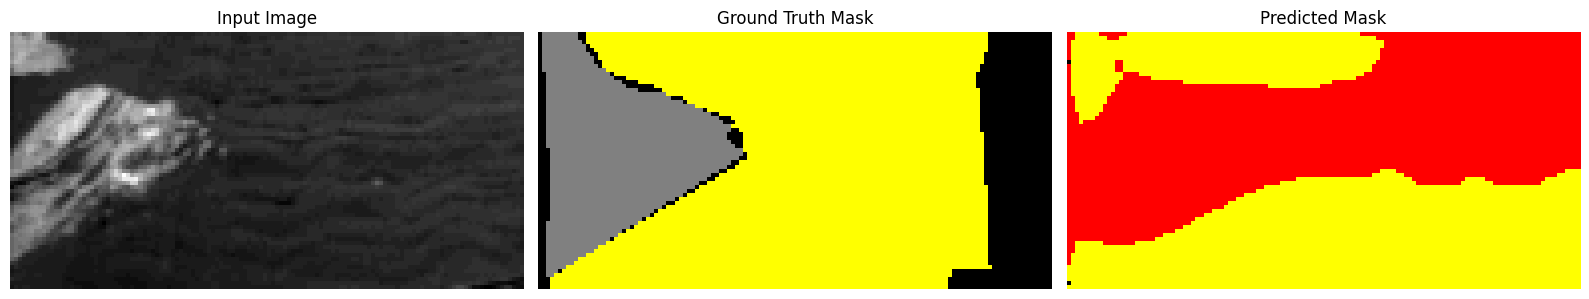

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.7670 - loss: 0.0342 - mean_intersection_over_union: 0.5011 - val_accuracy: 0.5574 - val_loss: 0.0434 - val_mean_intersection_over_union: 0.3045
Epoch 47/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7680 - loss: 0.0341 - mean_intersection_over_union: 0.4983 - val_accuracy: 0.6877 - val_loss: 0.0424 - val_mean_intersection_over_union: 0.4179
Epoch 48/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7444 - loss: 0.0349 - mean_intersection_over_union: 0.4525 - val_accuracy: 0.7128 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.4340
Epoch 49/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7690 - loss: 0.0341 - mean_intersection_over_union: 0.4878 - val_accuracy: 0.5590 - val_loss: 0.0433 - val_mean_intersection_over_union: 0.3027
Epoch 50/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7443 - loss: 0.0347 - mean_intersection_over_union: 0.4539 - val_accuracy: 0.6809 

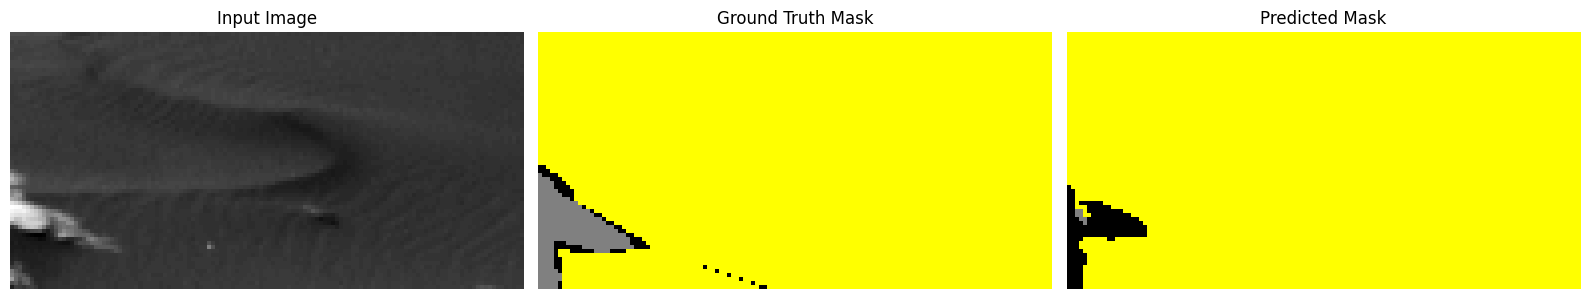

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.7671 - loss: 0.0341 - mean_intersection_over_union: 0.4890 - val_accuracy: 0.6706 - val_loss: 0.0423 - val_mean_intersection_over_union: 0.3992
Epoch 52/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7749 - loss: 0.0340 - mean_intersection_over_union: 0.4992 - val_accuracy: 0.7257 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.4497
Epoch 53/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7724 - loss: 0.0340 - mean_intersection_over_union: 0.4926 - val_accuracy: 0.6770 - val_loss: 0.0423 - val_mean_intersection_over_union: 0.3884
Epoch 54/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7611 - loss: 0.0344 - mean_intersection_over_union: 0.4746 - val_accuracy: 0.6776 - val_loss: 0.0404 - val_mean_intersection_over_union: 0.4062
Epoch 55/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7725 - loss: 0.0340 - mean_intersection_over_union: 0.4912 - val_accuracy: 0.7279 

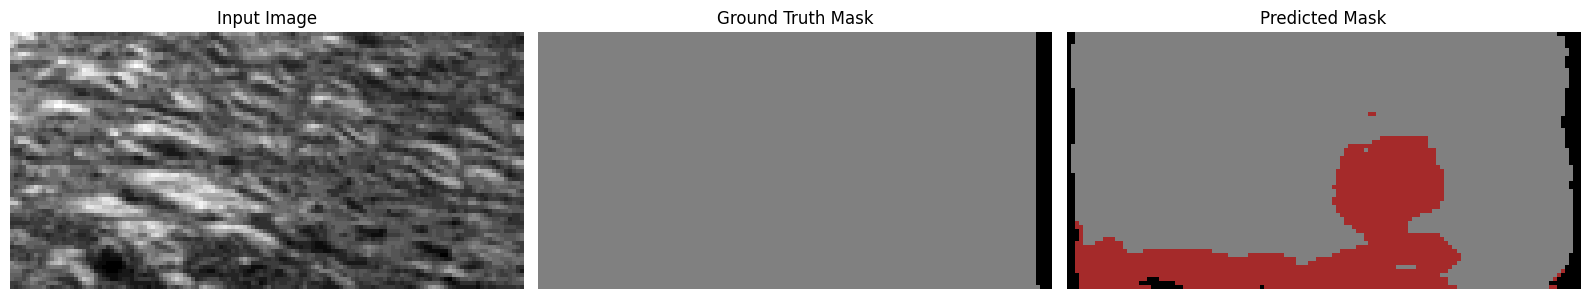

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.7829 - loss: 0.0337 - mean_intersection_over_union: 0.5125 - val_accuracy: 0.6851 - val_loss: 0.0416 - val_mean_intersection_over_union: 0.3929
Epoch 57/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7840 - loss: 0.0337 - mean_intersection_over_union: 0.5023 - val_accuracy: 0.5537 - val_loss: 0.0411 - val_mean_intersection_over_union: 0.3047
Epoch 58/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7746 - loss: 0.0339 - mean_intersection_over_union: 0.4905 - val_accuracy: 0.4694 - val_loss: 0.0449 - val_mean_intersection_over_union: 0.2403
Epoch 59/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7728 - loss: 0.0340 - mean_intersection_over_union: 0.4908 - val_accuracy: 0.7636 - val_loss: 0.0409 - val_mean_intersection_over_union: 0.4881
Epoch 60/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7878 - loss: 0.0336 - mean_intersection_over_union: 0.5160 - val_accuracy: 0.7292 

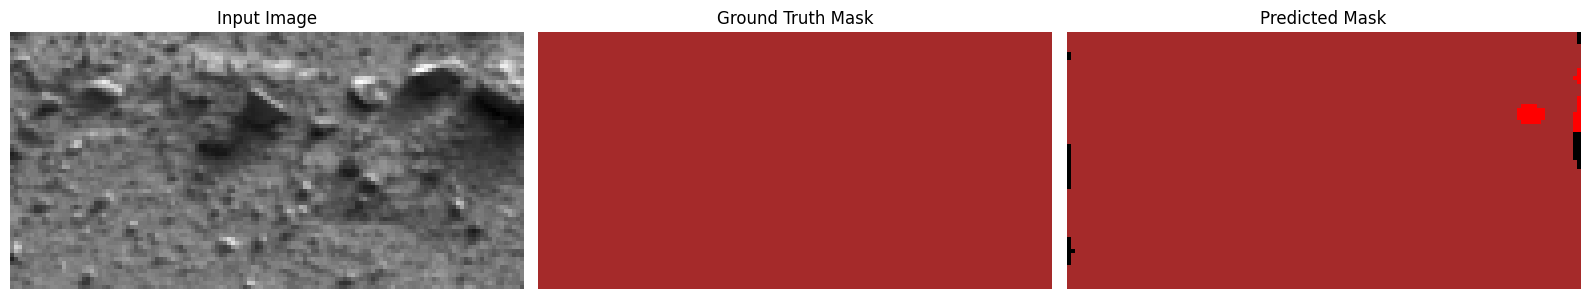

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.7895 - loss: 0.0335 - mean_intersection_over_union: 0.5133 - val_accuracy: 0.7664 - val_loss: 0.0405 - val_mean_intersection_over_union: 0.4936
Epoch 62/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7938 - loss: 0.0334 - mean_intersection_over_union: 0.5287 - val_accuracy: 0.6686 - val_loss: 0.0428 - val_mean_intersection_over_union: 0.3984
Epoch 63/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7937 - loss: 0.0334 - mean_intersection_over_union: 0.5345 - val_accuracy: 0.7227 - val_loss: 0.0412 - val_mean_intersection_over_union: 0.4386
Epoch 64/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7960 - loss: 0.0334 - mean_intersection_over_union: 0.5277 - val_accuracy: 0.5798 - val_loss: 0.0422 - val_mean_intersection_over_union: 0.3294
Epoch 65/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7850 - loss: 0.0337 - mean_intersection_over_union: 0.4966 - val_accuracy: 0.7560 

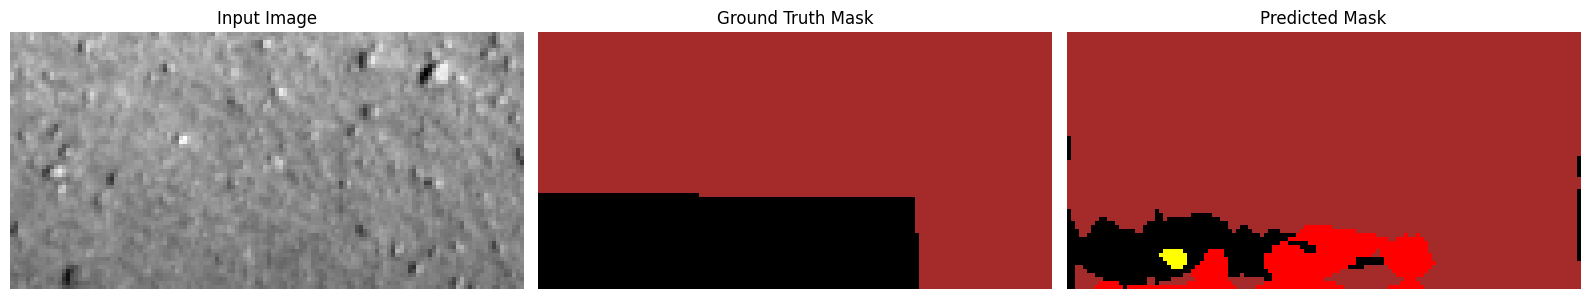

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.7996 - loss: 0.0333 - mean_intersection_over_union: 0.5250 - val_accuracy: 0.7108 - val_loss: 0.0410 - val_mean_intersection_over_union: 0.4230
Epoch 67/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8003 - loss: 0.0332 - mean_intersection_over_union: 0.5362 - val_accuracy: 0.7622 - val_loss: 0.0407 - val_mean_intersection_over_union: 0.4757
Epoch 68/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8063 - loss: 0.0331 - mean_intersection_over_union: 0.5599 - val_accuracy: 0.6103 - val_loss: 0.0428 - val_mean_intersection_over_union: 0.3411
Epoch 69/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8061 - loss: 0.0331 - mean_intersection_over_union: 0.5473 - val_accuracy: 0.5367 - val_loss: 0.0434 - val_mean_intersection_over_union: 0.2910
Epoch 70/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7977 - loss: 0.0333 - mean_intersection_over_union: 0.5247 - val_accuracy: 0.7179 

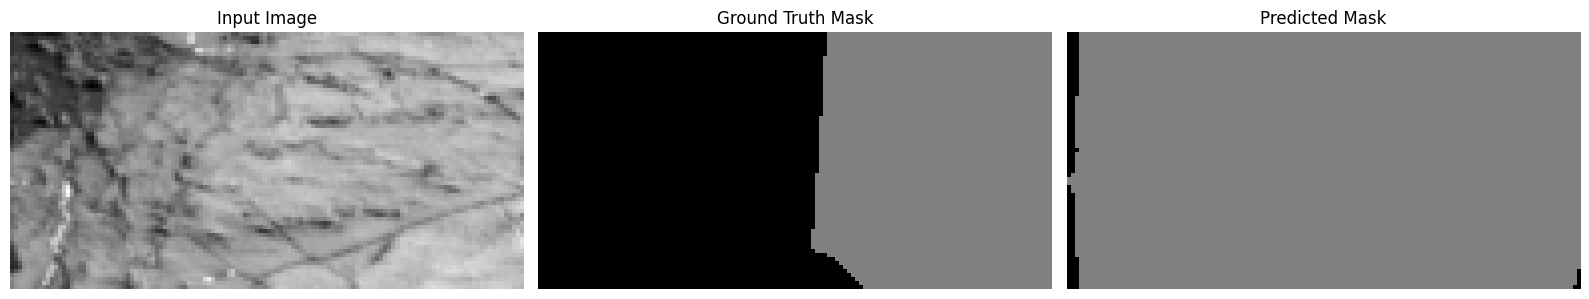

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8010 - loss: 0.0333 - mean_intersection_over_union: 0.5200 - val_accuracy: 0.7734 - val_loss: 0.0412 - val_mean_intersection_over_union: 0.4971
Epoch 72/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8180 - loss: 0.0328 - mean_intersection_over_union: 0.5738 - val_accuracy: 0.7366 - val_loss: 0.0422 - val_mean_intersection_over_union: 0.4443
Epoch 73/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8162 - loss: 0.0328 - mean_intersection_over_union: 0.5623 - val_accuracy: 0.6510 - val_loss: 0.0445 - val_mean_intersection_over_union: 0.3713
Epoch 74/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7994 - loss: 0.0333 - mean_intersection_over_union: 0.5181 - val_accuracy: 0.7338 - val_loss: 0.0424 - val_mean_intersection_over_union: 0.4370
Epoch 75/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8104 - loss: 0.0330 - mean_intersection_over_union: 0.5593 - val_accuracy: 0.7584 

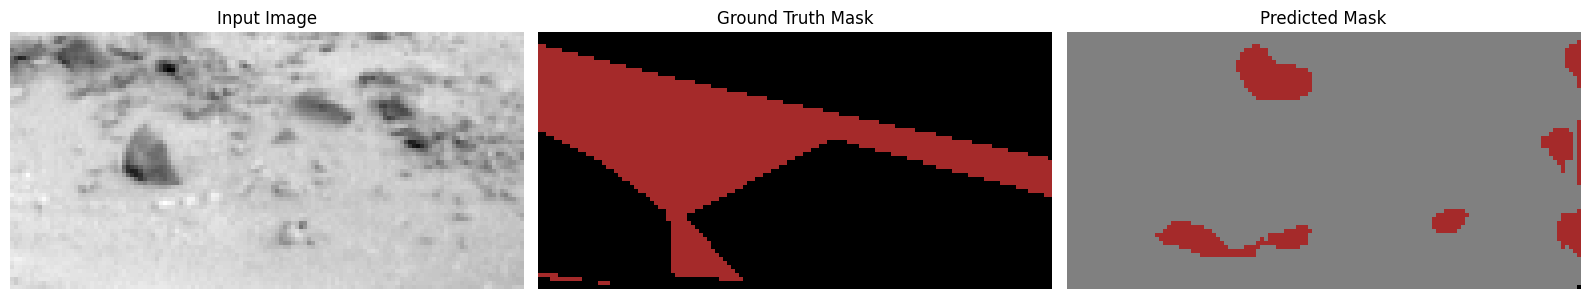

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8161 - loss: 0.0328 - mean_intersection_over_union: 0.5486 - val_accuracy: 0.7629 - val_loss: 0.0416 - val_mean_intersection_over_union: 0.4720
Epoch 77/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7669 - loss: 0.0344 - mean_intersection_over_union: 0.4695 - val_accuracy: 0.7150 - val_loss: 0.0422 - val_mean_intersection_over_union: 0.4310
Epoch 78/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8116 - loss: 0.0330 - mean_intersection_over_union: 0.5329 - val_accuracy: 0.7688 - val_loss: 0.0420 - val_mean_intersection_over_union: 0.4770
Epoch 79/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8144 - loss: 0.0329 - mean_intersection_over_union: 0.5432 - val_accuracy: 0.4439 - val_loss: 0.0478 - val_mean_intersection_over_union: 0.2075
Epoch 80/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8088 - loss: 0.0331 - mean_intersection_over_union: 0.5203 - val_accuracy: 0.7674 

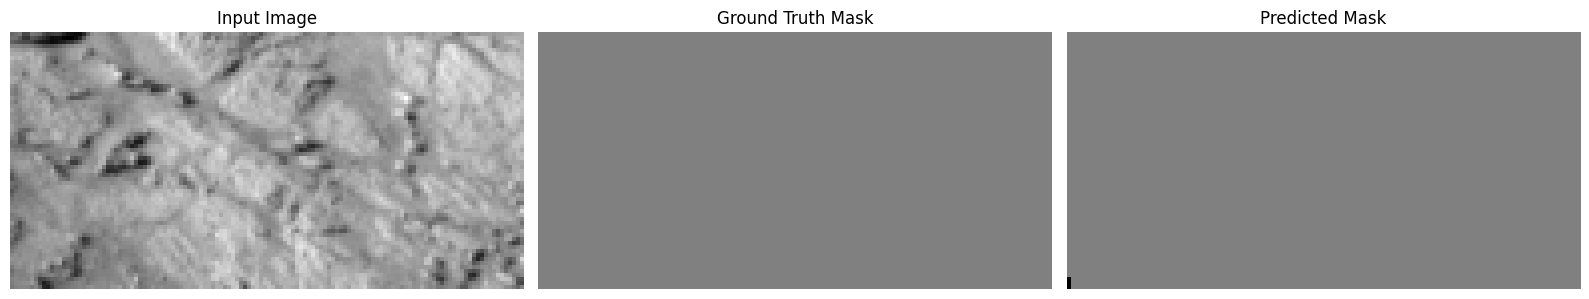

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8247 - loss: 0.0326 - mean_intersection_over_union: 0.5713 - val_accuracy: 0.6349 - val_loss: 0.0436 - val_mean_intersection_over_union: 0.3622
Epoch 82/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8079 - loss: 0.0332 - mean_intersection_over_union: 0.5213 - val_accuracy: 0.7686 - val_loss: 0.0417 - val_mean_intersection_over_union: 0.4784
Epoch 83/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8302 - loss: 0.0324 - mean_intersection_over_union: 0.5954 - val_accuracy: 0.7733 - val_loss: 0.0409 - val_mean_intersection_over_union: 0.4922
Epoch 84/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8328 - loss: 0.0324 - mean_intersection_over_union: 0.6047 - val_accuracy: 0.7746 - val_loss: 0.0415 - val_mean_intersection_over_union: 0.4771
Epoch 85/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8355 - loss: 0.0323 - mean_intersection_over_union: 0.6104 - val_accuracy: 0.7703 

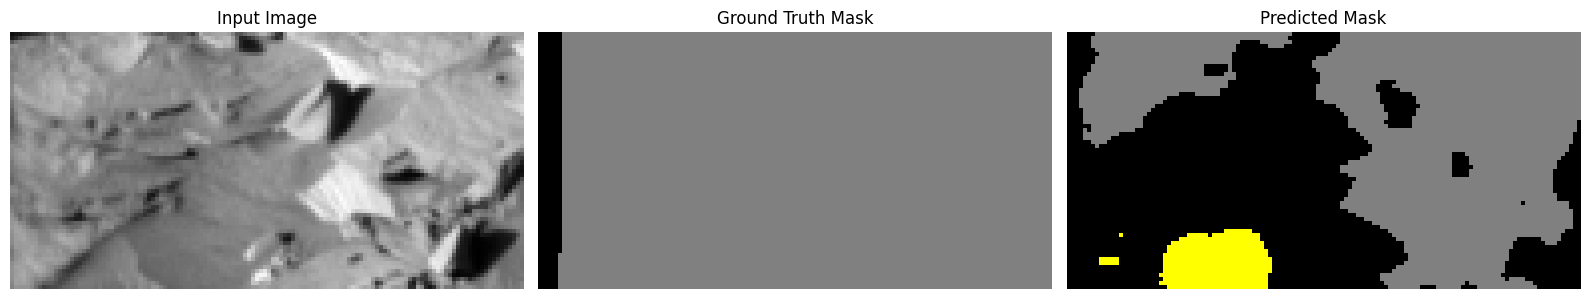

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8384 - loss: 0.0322 - mean_intersection_over_union: 0.6161 - val_accuracy: 0.7731 - val_loss: 0.0418 - val_mean_intersection_over_union: 0.4767
Epoch 87/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8389 - loss: 0.0323 - mean_intersection_over_union: 0.6030 - val_accuracy: 0.7506 - val_loss: 0.0405 - val_mean_intersection_over_union: 0.4654
Epoch 88/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8327 - loss: 0.0324 - mean_intersection_over_union: 0.5707 - val_accuracy: 0.7213 - val_loss: 0.0415 - val_mean_intersection_over_union: 0.4279
Epoch 89/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8350 - loss: 0.0324 - mean_intersection_over_union: 0.5719 - val_accuracy: 0.7446 - val_loss: 0.0423 - val_mean_intersection_over_union: 0.4450
Epoch 90/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8334 - loss: 0.0324 - mean_intersection_over_union: 0.5832 - val_accuracy: 0.7250 

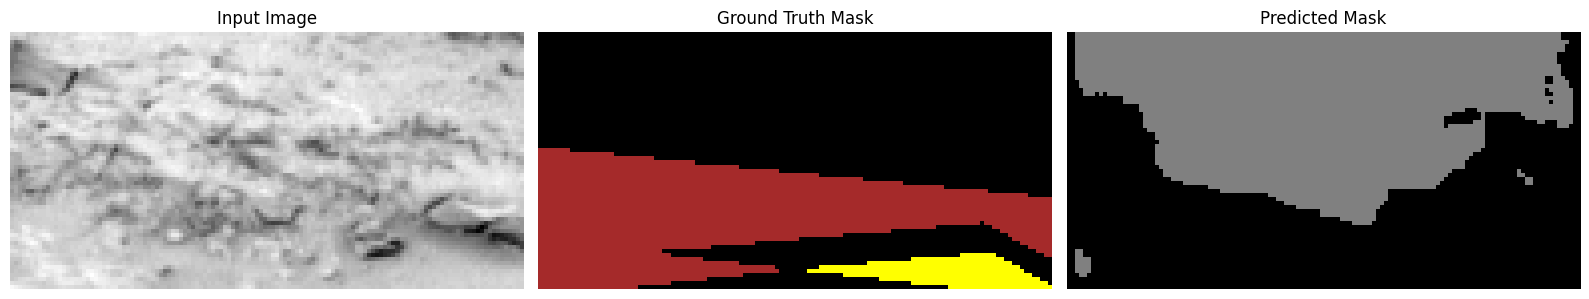

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8405 - loss: 0.0322 - mean_intersection_over_union: 0.6067 - val_accuracy: 0.7481 - val_loss: 0.0414 - val_mean_intersection_over_union: 0.4660
Epoch 92/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8447 - loss: 0.0321 - mean_intersection_over_union: 0.6190 - val_accuracy: 0.7514 - val_loss: 0.0416 - val_mean_intersection_over_union: 0.4652
Epoch 93/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8434 - loss: 0.0321 - mean_intersection_over_union: 0.6122 - val_accuracy: 0.7630 - val_loss: 0.0412 - val_mean_intersection_over_union: 0.4734
Epoch 94/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8462 - loss: 0.0320 - mean_intersection_over_union: 0.6074 - val_accuracy: 0.6852 - val_loss: 0.0431 - val_mean_intersection_over_union: 0.4033
Epoch 95/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8397 - loss: 0.0322 - mean_intersection_over_union: 0.5831 - val_accuracy: 0.7592 

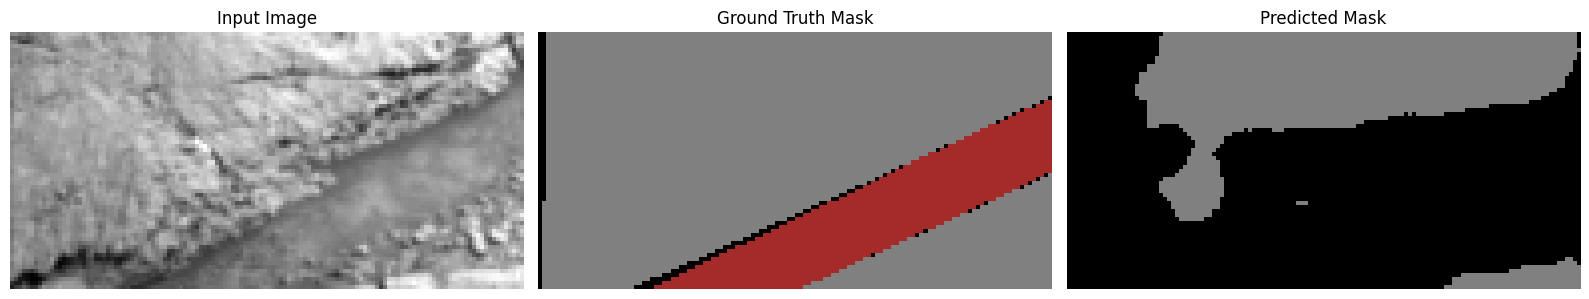

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8511 - loss: 0.0319 - mean_intersection_over_union: 0.5906 - val_accuracy: 0.7565 - val_loss: 0.0418 - val_mean_intersection_over_union: 0.4708
Epoch 97/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8514 - loss: 0.0319 - mean_intersection_over_union: 0.6268 - val_accuracy: 0.6944 - val_loss: 0.0418 - val_mean_intersection_over_union: 0.4171
Epoch 98/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8486 - loss: 0.0320 - mean_intersection_over_union: 0.6112 - val_accuracy: 0.6877 - val_loss: 0.0419 - val_mean_intersection_over_union: 0.4151
Epoch 99/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8549 - loss: 0.0318 - mean_intersection_over_union: 0.6202 - val_accuracy: 0.7775 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.4917
Epoch 100/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8568 - loss: 0.0318 - mean_intersection_over_union: 0.6215 - val_accuracy: 0.7564

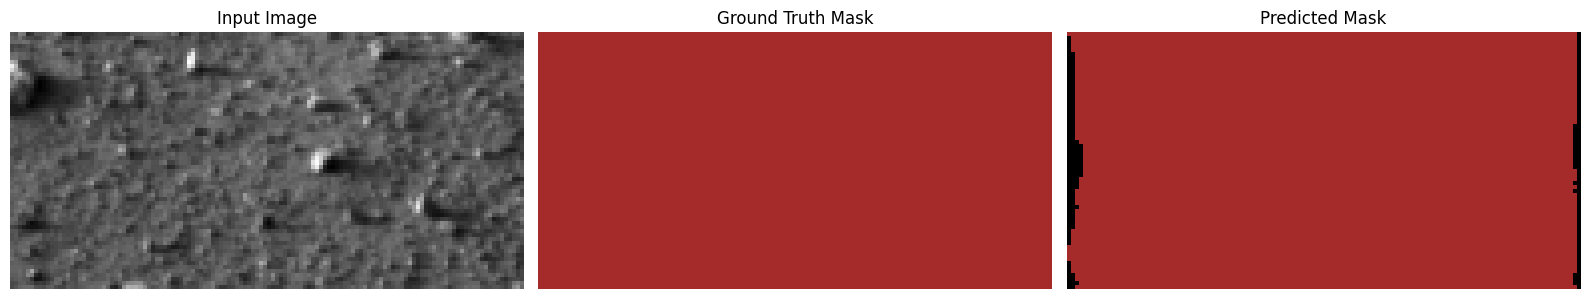

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8579 - loss: 0.0317 - mean_intersection_over_union: 0.6235 - val_accuracy: 0.7666 - val_loss: 0.0405 - val_mean_intersection_over_union: 0.4883
Epoch 102/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8618 - loss: 0.0316 - mean_intersection_over_union: 0.6215 - val_accuracy: 0.5716 - val_loss: 0.0442 - val_mean_intersection_over_union: 0.3203
Epoch 103/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8481 - loss: 0.0320 - mean_intersection_over_union: 0.5898 - val_accuracy: 0.7392 - val_loss: 0.0416 - val_mean_intersection_over_union: 0.4502
Epoch 104/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8560 - loss: 0.0318 - mean_intersection_over_union: 0.6105 - val_accuracy: 0.7670 - val_loss: 0.0409 - val_mean_intersection_over_union: 0.4858
Epoch 105/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8527 - loss: 0.0319 - mean_intersection_over_union: 0.6090 - val_accuracy: 0.7

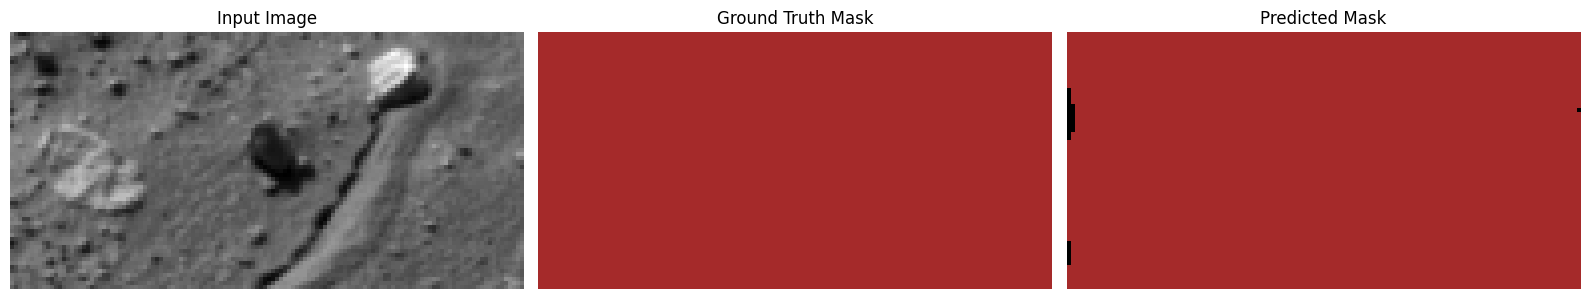

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8586 - loss: 0.0317 - mean_intersection_over_union: 0.6037 - val_accuracy: 0.7722 - val_loss: 0.0412 - val_mean_intersection_over_union: 0.4919
Epoch 107/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8599 - loss: 0.0317 - mean_intersection_over_union: 0.6179 - val_accuracy: 0.7398 - val_loss: 0.0417 - val_mean_intersection_over_union: 0.4437
Epoch 108/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8632 - loss: 0.0315 - mean_intersection_over_union: 0.6260 - val_accuracy: 0.7275 - val_loss: 0.0419 - val_mean_intersection_over_union: 0.4542
Epoch 109/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8712 - loss: 0.0313 - mean_intersection_over_union: 0.6431 - val_accuracy: 0.7410 - val_loss: 0.0412 - val_mean_intersection_over_union: 0.4549
Epoch 110/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8628 - loss: 0.0316 - mean_intersection_over_union: 0.6064 - val_accuracy: 0.7

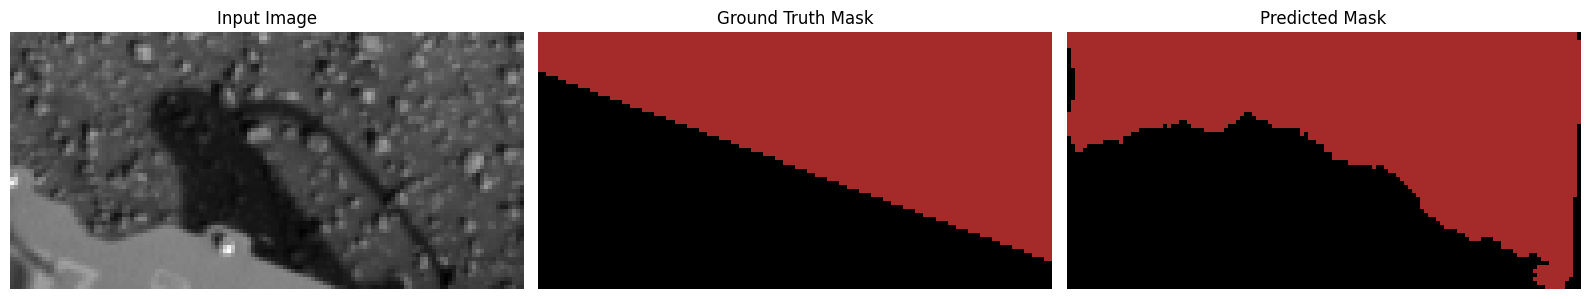

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8742 - loss: 0.0312 - mean_intersection_over_union: 0.6413 - val_accuracy: 0.7767 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.5006
Epoch 112/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8750 - loss: 0.0312 - mean_intersection_over_union: 0.6456 - val_accuracy: 0.7129 - val_loss: 0.0423 - val_mean_intersection_over_union: 0.4160
Epoch 113/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8747 - loss: 0.0312 - mean_intersection_over_union: 0.6218 - val_accuracy: 0.7511 - val_loss: 0.0417 - val_mean_intersection_over_union: 0.4641
Epoch 114/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8770 - loss: 0.0312 - mean_intersection_over_union: 0.6563 - val_accuracy: 0.6914 - val_loss: 0.0424 - val_mean_intersection_over_union: 0.4171
Epoch 115/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8736 - loss: 0.0312 - mean_intersection_over_union: 0.6509 - val_accuracy: 0.7

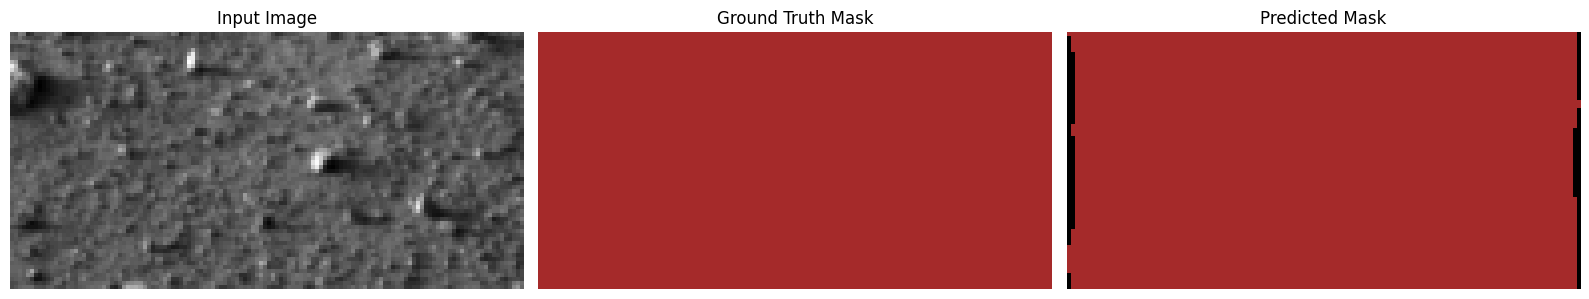

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8732 - loss: 0.0312 - mean_intersection_over_union: 0.6387 - val_accuracy: 0.6884 - val_loss: 0.0428 - val_mean_intersection_over_union: 0.4112
Epoch 117/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8776 - loss: 0.0311 - mean_intersection_over_union: 0.6441 - val_accuracy: 0.7656 - val_loss: 0.0422 - val_mean_intersection_over_union: 0.4597
Epoch 118/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8559 - loss: 0.0317 - mean_intersection_over_union: 0.5704 - val_accuracy: 0.6032 - val_loss: 0.0447 - val_mean_intersection_over_union: 0.3182
Epoch 119/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8557 - loss: 0.0317 - mean_intersection_over_union: 0.5715 - val_accuracy: 0.7731 - val_loss: 0.0418 - val_mean_intersection_over_union: 0.4752
Epoch 120/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8780 - loss: 0.0311 - mean_intersection_over_union: 0.6519 - val_accuracy: 0.7

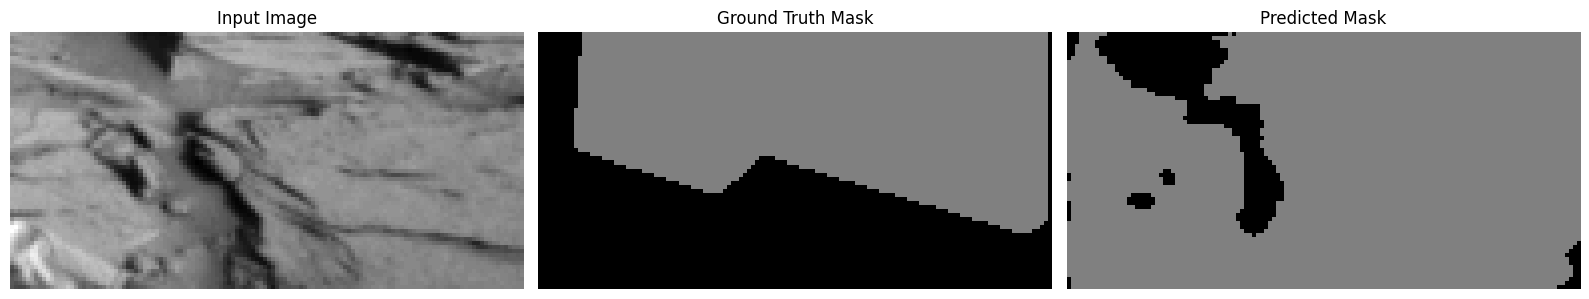

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8797 - loss: 0.0311 - mean_intersection_over_union: 0.6398 - val_accuracy: 0.7671 - val_loss: 0.0415 - val_mean_intersection_over_union: 0.4806
Epoch 122/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8850 - loss: 0.0310 - mean_intersection_over_union: 0.6566 - val_accuracy: 0.7481 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.4679
Epoch 123/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8879 - loss: 0.0309 - mean_intersection_over_union: 0.6635 - val_accuracy: 0.7267 - val_loss: 0.0424 - val_mean_intersection_over_union: 0.4484
Epoch 124/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8733 - loss: 0.0313 - mean_intersection_over_union: 0.6179 - val_accuracy: 0.7503 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.4731
Epoch 125/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8780 - loss: 0.0312 - mean_intersection_over_union: 0.6343 - val_accuracy: 0.7

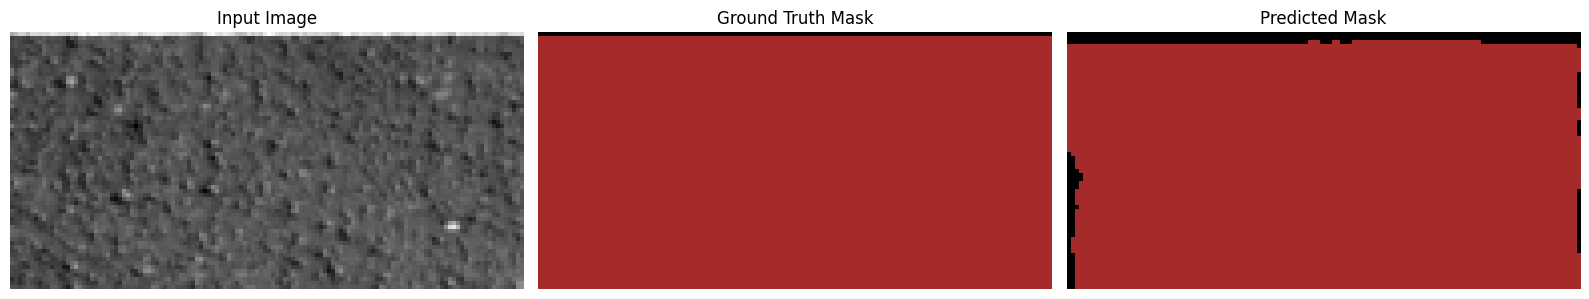

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8899 - loss: 0.0308 - mean_intersection_over_union: 0.6738 - val_accuracy: 0.7100 - val_loss: 0.0426 - val_mean_intersection_over_union: 0.4331
Epoch 127/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8920 - loss: 0.0308 - mean_intersection_over_union: 0.6801 - val_accuracy: 0.7355 - val_loss: 0.0423 - val_mean_intersection_over_union: 0.4481
Epoch 128/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8922 - loss: 0.0307 - mean_intersection_over_union: 0.6900 - val_accuracy: 0.7494 - val_loss: 0.0418 - val_mean_intersection_over_union: 0.4676
Epoch 129/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8928 - loss: 0.0307 - mean_intersection_over_union: 0.6748 - val_accuracy: 0.7654 - val_loss: 0.0419 - val_mean_intersection_over_union: 0.4754
Epoch 130/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8906 - loss: 0.0308 - mean_intersection_over_union: 0.6599 - val_accuracy: 0.7

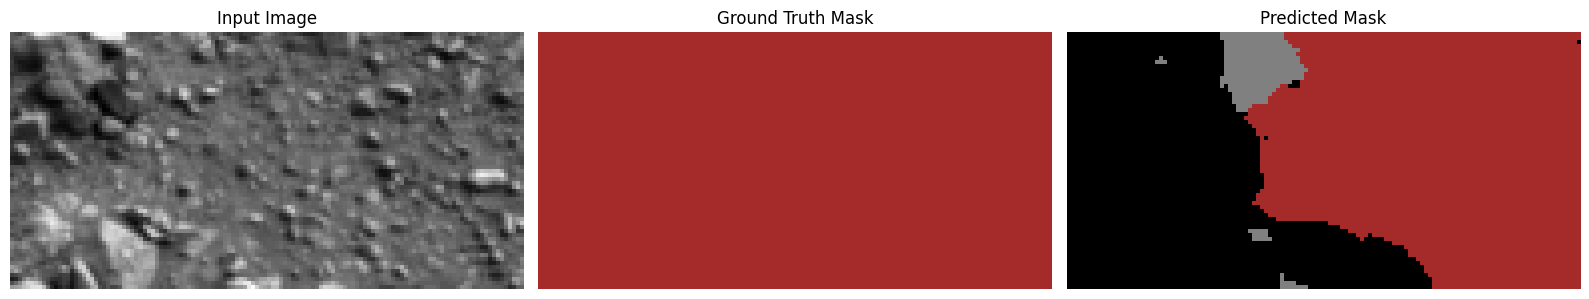

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.8799 - loss: 0.0311 - mean_intersection_over_union: 0.6256 - val_accuracy: 0.7121 - val_loss: 0.0431 - val_mean_intersection_over_union: 0.4200
Epoch 132/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8878 - loss: 0.0309 - mean_intersection_over_union: 0.6372 - val_accuracy: 0.7759 - val_loss: 0.0414 - val_mean_intersection_over_union: 0.4954
Epoch 133/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8857 - loss: 0.0309 - mean_intersection_over_union: 0.6412 - val_accuracy: 0.7728 - val_loss: 0.0421 - val_mean_intersection_over_union: 0.4876
Epoch 134/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8892 - loss: 0.0308 - mean_intersection_over_union: 0.6537 - val_accuracy: 0.7706 - val_loss: 0.0420 - val_mean_intersection_over_union: 0.4761
Epoch 135/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8958 - loss: 0.0306 - mean_intersection_over_union: 0.6576 - val_accuracy: 0.7

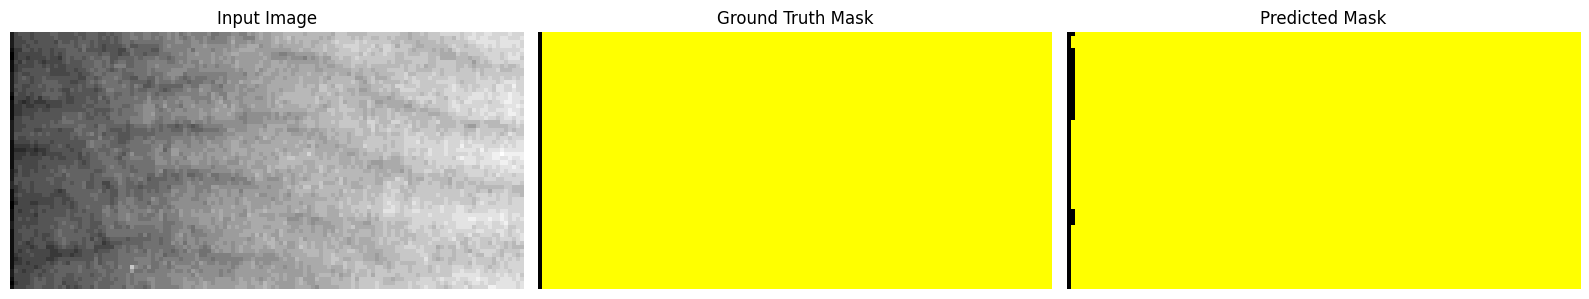

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.8991 - loss: 0.0305 - mean_intersection_over_union: 0.6872 - val_accuracy: 0.7590 - val_loss: 0.0424 - val_mean_intersection_over_union: 0.4578
Epoch 137/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8948 - loss: 0.0306 - mean_intersection_over_union: 0.6772 - val_accuracy: 0.7821 - val_loss: 0.0421 - val_mean_intersection_over_union: 0.4837
Epoch 138/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8981 - loss: 0.0306 - mean_intersection_over_union: 0.6792 - val_accuracy: 0.7619 - val_loss: 0.0413 - val_mean_intersection_over_union: 0.4781
Epoch 139/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8795 - loss: 0.0310 - mean_intersection_over_union: 0.6092 - val_accuracy: 0.6156 - val_loss: 0.0447 - val_mean_intersection_over_union: 0.3561
Epoch 140/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8959 - loss: 0.0306 - mean_intersection_over_union: 0.6637 - val_accuracy: 0.7

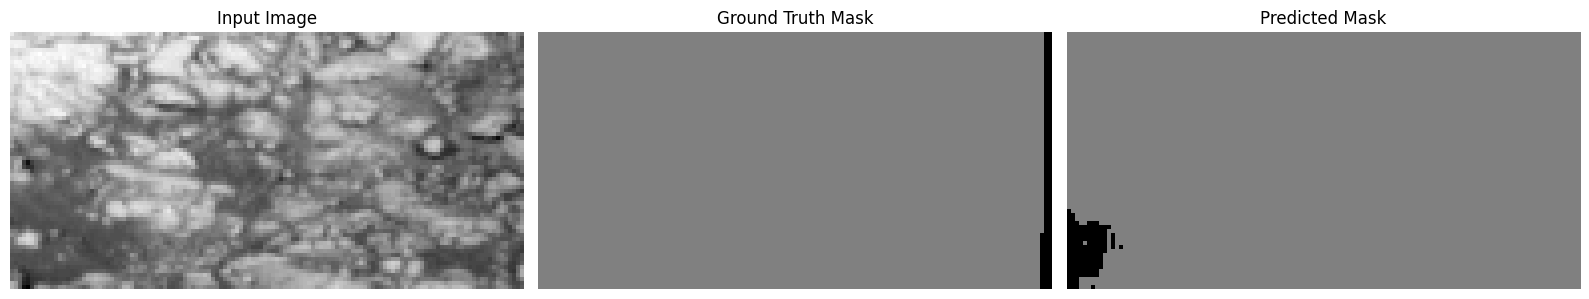

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.9000 - loss: 0.0305 - mean_intersection_over_union: 0.6648 - val_accuracy: 0.7579 - val_loss: 0.0419 - val_mean_intersection_over_union: 0.4670
Epoch 142/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9040 - loss: 0.0304 - mean_intersection_over_union: 0.6784 - val_accuracy: 0.6178 - val_loss: 0.0432 - val_mean_intersection_over_union: 0.3694
Epoch 143/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8885 - loss: 0.0308 - mean_intersection_over_union: 0.6239 - val_accuracy: 0.7181 - val_loss: 0.0422 - val_mean_intersection_over_union: 0.4267
Epoch 144/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.8978 - loss: 0.0306 - mean_intersection_over_union: 0.6449 - val_accuracy: 0.7308 - val_loss: 0.0421 - val_mean_intersection_over_union: 0.4419
Epoch 145/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9037 - loss: 0.0304 - mean_intersection_over_union: 0.6731 - val_accuracy: 0.7

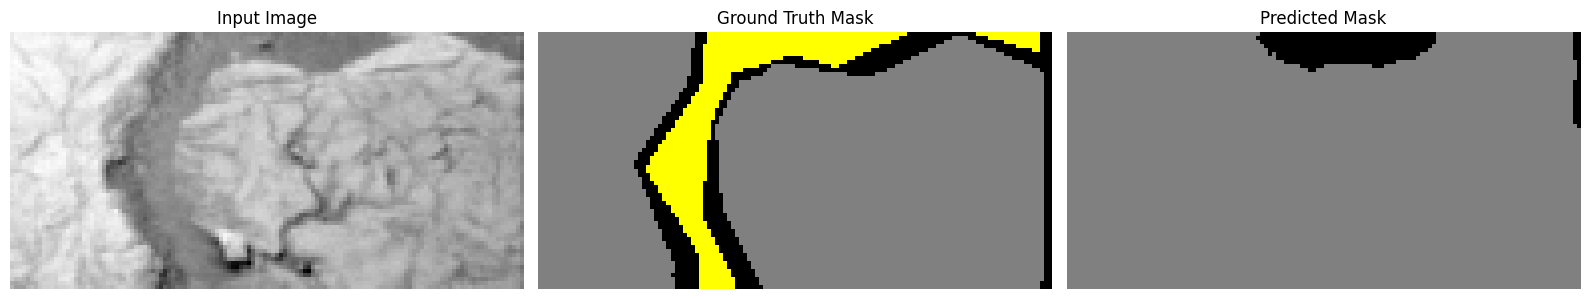

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9069 - loss: 0.0303 - mean_intersection_over_union: 0.6808 - val_accuracy: 0.7482 - val_loss: 0.0419 - val_mean_intersection_over_union: 0.4641
Epoch 147/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9093 - loss: 0.0303 - mean_intersection_over_union: 0.6960 - val_accuracy: 0.7556 - val_loss: 0.0422 - val_mean_intersection_over_union: 0.4630
Epoch 148/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9095 - loss: 0.0303 - mean_intersection_over_union: 0.6950 - val_accuracy: 0.7466 - val_loss: 0.0420 - val_mean_intersection_over_union: 0.4639
Epoch 149/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9106 - loss: 0.0302 - mean_intersection_over_union: 0.6831 - val_accuracy: 0.7129 - val_loss: 0.0430 - val_mean_intersection_over_union: 0.4228
Epoch 150/230
159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9093 - loss: 0.0303 - mean_intersection_over_union: 0.6922 - val_accuracy: 0.7

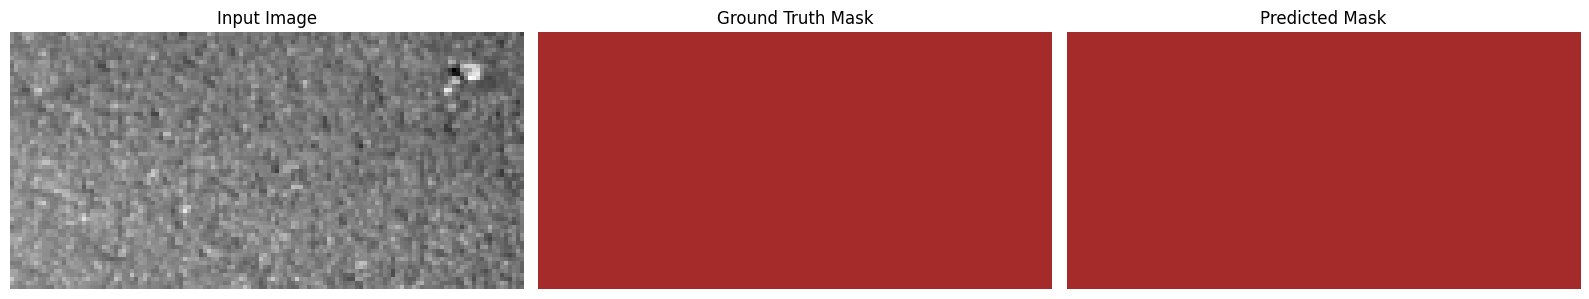

159/159 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8929 - loss: 0.0307 - mean_intersection_over_union: 0.6423 - val_accuracy: 0.7661 - val_loss: 0.0414 - val_mean_intersection_over_union: 0.4879
Final validation Mean Intersection Over Union: 50.06%


In [ ]:
from matplotlib.colors import ListedColormap

# Train the model
history = model.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, viz_callback],
    verbose=1
)


final_val_meanIoU = round(max(history.history['val_mean_intersection_over_union']) * 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

model_filename = f'UNet_valIoU{final_val_meanIoU}.keras'
model.save(model_filename)

del model

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_valIoU50.06.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:

timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"/kaggle/working/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved as: {submission_filename}")

Submission file saved as: /kaggle/working/submission_UNet_valIoU50.06.csv
